# Load data and packages



In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import transformers as ppb

In [3]:
#from google.colab import drive

#drive.mount("/content/gdrive")

In [4]:
my_dir = "C:/Users/antoi/Downloads/"

raw_data = pd.read_csv(my_dir + "our_data_4.csv") # now 20000 rows

In [5]:
from collections import Counter
print(Counter(raw_data['type'].values))
print(Counter(raw_data['target'].values))

Counter({'reliable': 5000, 'fake': 5000, 'political': 4000, 'conspiracy': 2000, 'junksci': 2000, 'satire': 1000, 'bias': 1000})
Counter({'REAL': 10000, 'FAKE': 10000})


In [6]:
# take only content, drop other variables
content_data = raw_data[["id","type","content","target"]].copy()
content_data["id"] = content_data["id"].astype(int) # check article id to be integer

In [7]:
# now just shuffle rows (not necessary)
data = content_data.sample(frac=1, random_state = 42).reset_index(drop=True)
data.head()

,id,type,content,target
0,342901,conspiracy,edit on 12/6/14 by JiggyPotamus because: (no r...,FAKE
1,483414,reliable,"In heaven, people will have a similar body, vo...",REAL
2,344499,political,The East Wing's steady decline in promoting hi...,REAL
3,929267,reliable,(Photo: REUTERS/Dominick Reuter) Boston police...,REAL
4,37356,fake,University Sued For Limiting Free Speech To Lu...,FAKE


# Prepare data

## Use DistilBERT

In [8]:
def embeddings_distilbert(content_data, batch_size):
  import transformers as ppb # pytorch transformers
  import torch

  # Create tokenizer and model input
  dbert_tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
  dbert_model = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
  dbert_model.eval()

  # Tokenize input
  tokenized = content_data.apply((lambda x: dbert_tokenizer.encode(x, add_special_tokens=True)))
  print("Tokenization DONE")
  # Pad input so that all sequences are of the same size:
  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  # Actually, we can only deal with sequence lengths up to 512 with the DistilBert model, so we'll just truncate 
  padded = padded[:,:512]

  # Tell embedding model to disregard pad tokens
  attention_mask = np.where(padded != 0, 1, 0)
  print("Padding DONE")

  device = torch.device("cpu")
  if torch.cuda.is_available():
    model = dbert_model.cuda()
    device = torch.device("cuda")

  # Convert input to a pytorch tensor (so that it can be used as input for the embedding model)
  input = torch.tensor(np.array(padded), device=device)
  attention_mask = torch.tensor(attention_mask, device=device)

  # Embed sequences (processing in batches to avoid memory problems)
  #batch_size= 1
  embeddings = []
  for start_index in range(0, input.shape[0], batch_size):
    with torch.no_grad():
      # Call embedding model
      torch.cuda.empty_cache()
      embedding = dbert_model(input[start_index:start_index+batch_size], 
                      attention_mask=attention_mask[start_index:start_index+batch_size])[0][:,0,:]
      if start_index % 1000 == 0:
        print(start_index)
      embeddings.append(embedding.cpu().numpy())
    del embedding
  print("Embeddings DONE")

  # embeddings to numpy
  embeddings = np.array(embeddings)[:,0,:]
  #print(embeddings.shape) # print shape

  return embeddings

In [9]:
# Here get a data from DistilBERT - either calculate them and save or load them
load_mode = True # True = only load, False = recalculate

if load_mode:
  data_after_bert = pd.read_csv(my_dir + "data_after_bert_1.csv")
else:
  data_x = embeddings_distilbert(data["content"],1)
  data_after_bert = pd.concat([data, pd.DataFrame(data_x)], axis=1)
  data_after_bert.to_csv(my_dir + "data_after_bert.csv", index = False)

print(data_after_bert.shape)
data_after_bert.head()

(20000, 772)


,id,type,content,target,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,332176,conspiracy,edit on 4/18/17 by dragonridr because: (no rea...,FAKE,0.106311,0.088579,-0.097302,-0.322698,-0.362303,-0.214526,...,0.072385,-0.258892,-0.097093,-0.258708,0.272754,0.257194,-0.241443,-0.014499,0.543402,0.315260
1,552006,reliable,(Photo: Reuters/Fabrizio Bensch) Migrants who ...,REAL,-0.212137,0.055748,0.530093,-0.020321,0.031991,0.037772,...,0.288124,-0.087424,0.079782,-0.312908,-0.020711,-0.293428,-0.223143,-0.277556,0.222861,0.224410
2,996934,satire,"SAN FRANCISCO - USA - Niles Baccarat, 45, purc...",REAL,-0.095490,-0.174996,-0.085154,-0.006669,0.154215,-0.059694,...,-0.029326,-0.069607,-0.116903,-0.329485,0.007457,0.113285,-0.233248,-0.235345,0.535735,0.401071
3,989096,reliable,(Photo: Access Hollywood Live video screen gra...,REAL,0.018963,-0.113733,-0.010551,-0.012989,0.022653,-0.135272,...,0.039579,-0.252206,-0.047384,-0.434419,-0.102059,0.218546,0.035455,-0.001591,0.412287,0.018747
4,1098570,bias,"A Collection of Interesting, Important, and Co...",FAKE,-0.290180,-0.110230,-0.486127,-0.137644,-0.176239,-0.078951,...,0.056023,-0.014438,-0.099170,-0.302892,0.012635,-0.234282,0.142875,-0.149025,0.394698,0.260328


## Add features

In [10]:
# Feature functions
import re

def swearword_binary(string):
    swearwords =[ 'fuck ',' ass ',' asshole ',' bitch ',' fucking ','whore ','piss ','pussy ','shit ','dick ']
    temp = 0
    
    for word in swearwords :
        
          temp = temp + word_count(string, word) 
          
    if temp > 0:
        return 1
    else:
        return 0

def regex_check(article, error):
    result = 0

    error1_count = 0
    err_1 = re.findall(error, article)

    if len(err_1) != 0:
        error1_count += (len(err_1))
    
    result += error1_count
    return result

def voca_size_(article):
    res = []
    article = article.lower()

    word_list = article.split()

    for word in word_list:
        if word not in res:
            res += [word]
    
    return len(res)

def sentence_avg(text):
    nr_sentence = 1
    for c in text:
        if c == '.':
            nr_sentence += 1

    res = len(text)/nr_sentence
    return res

def word_count(article, word):
  
     a = article.upper()
  
     a = re.sub(r"[^A-Z]", "  ", a)
  
     a = " " + a + " "
  
     w = " " + word.upper() + " "
  
     return a.count(w)

def symbol_binary(string, symbol):
    if string.count(symbol) >0:
        return 1
    else:
        return 0

In [11]:
# Function to add all features

def add_features(dataframe, content_name):

    output_dataframe = dataframe.copy()

    output_dataframe["exclamation_mark_count"] = output_dataframe[content_name].map(lambda article: regex_check(article, '\!'))
    output_dataframe["exclamation_mark_binary"] = output_dataframe[content_name].map(lambda article: symbol_binary(article, '!'))
    output_dataframe["question_mark_count"] = output_dataframe[content_name].map(lambda article: regex_check(article, '\?'))
    output_dataframe["question_mark_binary"] = output_dataframe[content_name].map(lambda article: symbol_binary(article, '?'))
    output_dataframe["missing_whitespace_count"] = output_dataframe[content_name].map(lambda article: regex_check(article, '\.\w'))
    output_dataframe["vocabulary_size"] = output_dataframe[content_name].map(lambda article: voca_size_(article))
    output_dataframe["average_sentence_count"] = output_dataframe[content_name].map(lambda article: sentence_avg(article))
    output_dataframe["swearword_binary"] = output_dataframe[content_name].map(lambda article: swearword_binary(article))
    output_dataframe["free_count"] = output_dataframe[content_name].map(lambda article: word_count(article,"free"))
    output_dataframe["trump_count"] = output_dataframe[content_name].map(lambda article: word_count(article,"trump"))
    output_dataframe["dollar_count"] = output_dataframe[content_name].map(lambda article: word_count(article,"dollar"))

    return output_dataframe

In [12]:
modelling_data = add_features(data_after_bert, "content")
modelling_data.shape

(20000, 783)

# Modelling

## Split data to train, validation and test

In [13]:
# Define X and y
X = modelling_data.iloc[:,4:]
y = modelling_data["target"]

In [14]:
# Split train and test data
from sklearn.model_selection import train_test_split

indices = np.arange(y.shape[0]) # create indices of the split (usage like data.iloc[idx_val_test])

# split train and (validation+test)
X_train, X_val_test, y_train, y_val_test, idx_train, idx_val_test = train_test_split(X, y, indices, test_size = 0.30, random_state = 42, stratify = y)

# split validation and test
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(X_val_test, y_val_test, idx_val_test, 
                                                                                     test_size = 0.50, random_state = 42, stratify = y_val_test)

X_train.shape, X_val.shape, X_test.shape

((14000, 779), (3000, 779), (3000, 779))

## Random forest

our first, initial model

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=2, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

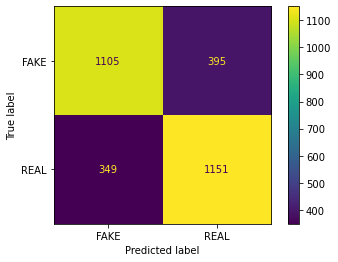

In [16]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(forest, X_test, y_test, values_format='.5g')  
plt.show()

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, forest.predict(X_test))

0.752

## Neural networks

so far only full connected NNs tried

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import torch.optim as optim

In [19]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

print(device)

cuda


### Prepare data for neural networks

In [20]:
# define functions
def y_to_numeric(y):
  return y.replace({"REAL": 0, "FAKE": 1})

def y_to_labels(y):
  return np.where(y==1,"FAKE","REAL")

# now transform
y_train = y_to_numeric(y_train)
y_val = y_to_numeric(y_val)
y_test = y_to_numeric(y_test)
y_is_numeric = True
print(y_is_numeric)

True


### Train and predict functions

In [21]:
def fit(X_train, y_train, X_val, y_val, model, optimizer, batch_size=32, epochs=5, loss_fn=F.mse_loss):   
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    n_iterations = len(X_train) // batch_size

    X_train = torch.tensor(X_train.to_numpy()).float()
    y_train = torch.tensor(y_train.to_numpy()).float()
    y_train = y_train.view(-1,1)

    X_val = torch.tensor(X_val.to_numpy()).float()
    y_val = torch.tensor(y_val.to_numpy()).float()
    y_val = y_val.view(-1,1)
    
    pbar = tqdm(total=n_iterations)
    loss_train_list = []
    loss_val_list = []
    for epoch in range(epochs):
        # shuffle iterator        
        idx = torch.randperm(len(X_train))
        epoch_loss = 0
        for i in range(n_iterations):
            optimizer.zero_grad()
            batch_idx = idx[i * batch_size: (i + 1) * batch_size]
            X_batch = X_train[batch_idx].to(device)
            y_batch = y_train[batch_idx].to(device)

            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            
            epoch_loss += loss.item()
            
            optimizer.step()
            
            # logging
            if i % 10 == 0:
                pbar.set_description_str(f"Epoch {epoch + 1}/{epochs}")
                pbar.set_postfix_str(f"loss: {loss.item():.4f}")
                pbar.update(10)

        epoch_loss = epoch_loss/n_iterations
        loss_train_list.append(epoch_loss)

        # get loss for validation data
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        y_pred_val = model(X_val)

        loss_val = loss_fn(y_pred_val, y_val)
        loss_val_list.append(loss_val.item())

        pbar.refresh()
        pbar.reset()
    return model, loss_train_list, loss_val_list       

In [22]:
def predict_prob(X, model):
    X = torch.tensor(X.to_numpy()).float()
    X = X.to(device)
    y_pred = model(X)[:,0]
    y_pred = y_pred.cpu().detach().numpy()
    return y_pred

def predict_binary(X, model, threshold=0.5):
    X = torch.tensor(X.to_numpy()).float()
    X = X.to(device)
    y_pred = model(X)[:,0]
    y_pred = y_pred.cpu().detach().numpy()
    y_pred_binary = np.where(y_pred>threshold,1,0)
    return y_pred_binary

### Define various networks

In [23]:
# network without hidden layer
class Net0(nn.Module):
    def __init__(self): 
        super().__init__()

        self.lin1 = nn.Linear(X_train.shape[1], 1)
        self.last_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = self.last_layer(x)
        return x

In [24]:
# network with 1 hidden layer
class Net1(nn.Module):
    def __init__(self, hidden_sz1: int):
        super().__init__()
        self.hidden_size1 = hidden_sz1

        self.lin1 = nn.Linear(X_train.shape[1], hidden_sz1)
        self.lin2 = nn.Linear(hidden_sz1, 1)
        self.activation = nn.ReLU()
        self.last_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = self.activation(x)
        x = self.lin2(x)
        x = self.last_layer(x)
        return x

In [25]:
# network with 2 hidden layers
class Net2(nn.Module):
    def __init__(self, hidden_sz1: int, hidden_sz2: int):
        super().__init__()
        self.hidden_size1 = hidden_sz1
        self.hidden_size2 = hidden_sz2

        self.lin1 = nn.Linear(X_train.shape[1], hidden_sz1)
        self.lin2 = nn.Linear(hidden_sz1, hidden_sz2)
        self.lin3 = nn.Linear(hidden_sz2, 1)
        self.activation = nn.ReLU()
        self.last_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = self.activation(x)
        x = self.lin2(x)
        x = self.activation(x)
        x = self.lin3(x)
        x = self.last_layer(x)
        return x

In [26]:
# network with 3 hidden layers
class Net3(nn.Module):
    def __init__(self, hidden_sz1: int, hidden_sz2: int, hidden_sz3: int):
        super().__init__()
        self.hidden_size1 = hidden_sz1
        self.hidden_size2 = hidden_sz2
        self.hidden_size3 = hidden_sz3

        self.lin1 = nn.Linear(X_train.shape[1], hidden_sz1)
        self.lin2 = nn.Linear(hidden_sz1, hidden_sz2)
        self.lin3 = nn.Linear(hidden_sz2, hidden_sz3)
        self.lin4 = nn.Linear(hidden_sz3, 1)
        self.activation = nn.ReLU()
        self.last_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = self.activation(x)
        x = self.lin2(x)
        x = self.activation(x)
        x = self.lin3(x)
        x = self.activation(x)
        x = self.lin4(x)
        x = self.last_layer(x)
        return x

In [27]:
net0 = Net0()
net1 = Net1(16)
net2 = Net2(128,16)
net3 = Net3(256,64,16)

print(net0, net1, net2, net3)

Net0(
  (lin1): Linear(in_features=779, out_features=1, bias=True)
  (last_layer): Sigmoid()
) Net1(
  (lin1): Linear(in_features=779, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
  (last_layer): Sigmoid()
) Net2(
  (lin1): Linear(in_features=779, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
  (last_layer): Sigmoid()
) Net3(
  (lin1): Linear(in_features=779, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
  (last_layer): Sigmoid()
)


### Train the models

In [28]:
# nets to GPU if available
net0.to(device)
net1.to(device)
net2.to(device)
net3.to(device)

# define optimizer and loss
optimizer0 = optim.Adam(net0.parameters(), lr=0.001)
optimizer1 = optim.Adam(net1.parameters(), lr=0.001)
optimizer2 = optim.Adam(net2.parameters(), lr=0.001)
optimizer3 = optim.Adam(net3.parameters(), lr=0.001)
my_loss = nn.BCELoss()

# define number of epochs and batch_size
n_epochs = 300 # 2000
batch_sz = 1000 #X_train.shape[0] # all in one batch

In [29]:
# train all nets
net0, loss_train_list0, loss_val_list0 = fit(X_train, y_train, X_val, y_val, net0, optimizer0, batch_size=batch_sz, epochs=n_epochs, loss_fn=my_loss)
net1, loss_train_list1, loss_val_list1 = fit(X_train, y_train, X_val, y_val, net1, optimizer1, batch_size=batch_sz, epochs=n_epochs, loss_fn=my_loss)
net2, loss_train_list2, loss_val_list2 = fit(X_train, y_train, X_val, y_val, net2, optimizer2, batch_size=batch_sz, epochs=n_epochs, loss_fn=my_loss)
net3, loss_train_list3, loss_val_list3 = fit(X_train, y_train, X_val, y_val, net3, optimizer3, batch_size=batch_sz, epochs=n_epochs, loss_fn=my_loss)

### Find the right number of epochs to avoid overfitting

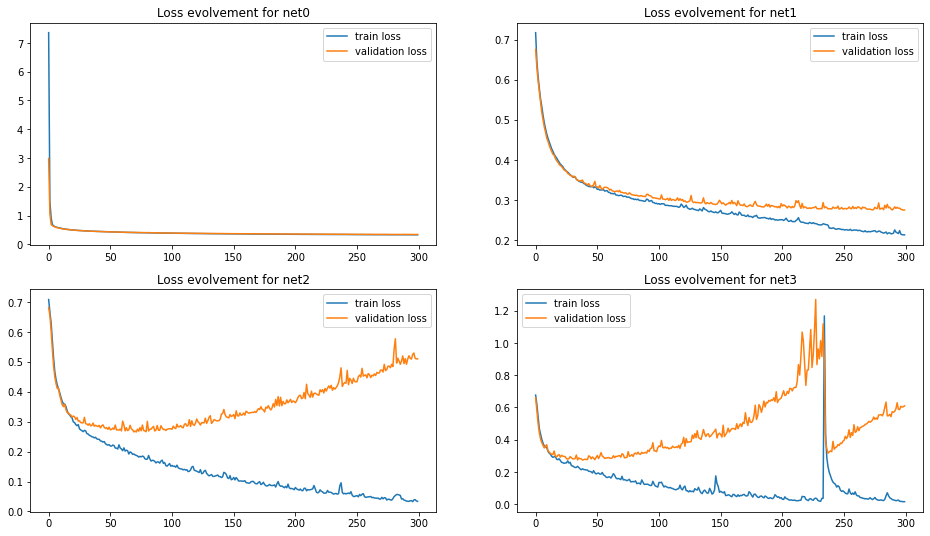

In [30]:
# plot evolvement of train and validation loss
saving_figures = False

fig=plt.figure(figsize=(16, 9))

fig.add_subplot(2, 2, 1)
plt.plot(loss_train_list0)
plt.plot(loss_val_list0)
plt.title("Loss evolvement for net0")
plt.legend(["train loss","validation loss"])

fig.add_subplot(2, 2, 2)
plt.plot(loss_train_list1)
plt.plot(loss_val_list1)
plt.title("Loss evolvement for net1")
plt.legend(["train loss","validation loss"])

fig.add_subplot(2, 2, 3)
plt.plot(loss_train_list2)
plt.plot(loss_val_list2)
plt.title("Loss evolvement for net2")
plt.legend(["train loss","validation loss"])

fig.add_subplot(2, 2, 4)
plt.plot(loss_train_list3)
plt.plot(loss_val_list3)
plt.title("Loss evolvement for net3")
plt.legend(["train loss","validation loss"])


if saving_figures:
  plt.savefig(my_dir + "losses.pdf", bbox_inches='tight')
plt.show()

In [31]:
# find the best number of epochs by lowest validation loss
best0 = np.argmin(loss_val_list0), np.min(loss_val_list0)
best1 = np.argmin(loss_val_list1), np.min(loss_val_list1)
best2 = np.argmin(loss_val_list2), np.min(loss_val_list2)
best3 = np.argmin(loss_val_list3), np.min(loss_val_list3)

best0, best1, best2, best3

((298, 0.33835461735725403),
 (298, 0.27517786622047424),
 (71, 0.26537972688674927),
 (38, 0.2737787365913391))

### Retrain models with the right number of epochs

In [32]:
# define all nets again
net0 = Net0()
net1 = Net1(16)
net2 = Net2(128,16)
net3 = Net3(256,64,16)

net0.to(device)
net1.to(device)
net2.to(device)
net3.to(device)

optimizer0 = optim.Adam(net0.parameters(), lr=0.001)
optimizer1 = optim.Adam(net1.parameters(), lr=0.001)
optimizer2 = optim.Adam(net2.parameters(), lr=0.001)
optimizer3 = optim.Adam(net3.parameters(), lr=0.001)

print(net0, net1, net2, net3)

Net0(
  (lin1): Linear(in_features=779, out_features=1, bias=True)
  (last_layer): Sigmoid()
) Net1(
  (lin1): Linear(in_features=779, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
  (last_layer): Sigmoid()
) Net2(
  (lin1): Linear(in_features=779, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
  (last_layer): Sigmoid()
) Net3(
  (lin1): Linear(in_features=779, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
  (last_layer): Sigmoid()
)


In [33]:
# train all nets again
net0, loss_train_list0, loss_val_list0 = fit(X_train, y_train, X_val, y_val, net0, optimizer0, batch_size=batch_sz, epochs=best0[0], loss_fn=my_loss)
net1, loss_train_list1, loss_val_list1 = fit(X_train, y_train, X_val, y_val, net1, optimizer1, batch_size=batch_sz, epochs=best1[0], loss_fn=my_loss)
net2, loss_train_list2, loss_val_list2 = fit(X_train, y_train, X_val, y_val, net2, optimizer2, batch_size=batch_sz, epochs=best2[0], loss_fn=my_loss)
net3, loss_train_list3, loss_val_list3 = fit(X_train, y_train, X_val, y_val, net3, optimizer3, batch_size=batch_sz, epochs=best3[0], loss_fn=my_loss)

### Evaluate the models

In [34]:
# calculate accuracy on test data
accuracy0 = accuracy_score(y_test, predict_binary(X_test, net0, 0.5))
accuracy1 = accuracy_score(y_test, predict_binary(X_test, net1, 0.5))
accuracy2 = accuracy_score(y_test, predict_binary(X_test, net2, 0.5))
accuracy3 = accuracy_score(y_test, predict_binary(X_test, net3, 0.5))

accuracy0, accuracy1, accuracy2, accuracy3

# -> net2 the best (possibly also net3)

(0.8496666666666667, 0.8793333333333333, 0.8836666666666667, 0.875)

# Predict on out-of sample data

## Various categories

In [35]:
allcat_data = pd.read_csv(my_dir + 'our_data_500.csv')
allcat_data.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,4336,929838.0,christianpost.com,reliable,https://www.christianpost.com/news/jesus-chris...,(Photo: Reuters/Danny Moloshok) Tyler Perry sp...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Roles of Jesus Christ, Judas Cast in Tyler Per...",NaN,NaN,[''],The actors who will portray Jesus Christ and J...,NaN,NaN,NaN
1,8066,934184.0,christianpost.com,reliable,https://www.christianpost.com/news/cannibalism...,(Screengrab: YouTube / RWW Blog) Televangelist...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Cannibalism in the End Times? Jim Bakker Says ...,NaN,NaN,[''],Televangelist Jim Bakker has warned viewers of...,NaN,NaN,NaN
2,2776,479786.0,nutritionfacts.org,reliable,https://nutritionfacts.org/audio/to-pee-or-not...,Hello and welcome to Nutrition Facts. I’m your...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,To Pee or not to Pee,NaN,NaN,[''],NaN,NaN,NaN,NaN
3,2070,781392.0,christianpost.com,reliable,https://www.christianpost.com/news/hp-ceo-leo-...,Hewlett-Packard Co has ousted CEO Leo Apotheke...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"HP CEO Leo Apotheker Fired, Meg Whitman Takes ...",NaN,NaN,[''],Hewlett-Packard Co has ousted CEO Leo Apotheke...,NaN,NaN,NaN
4,405,471.0,christianpost.com,reliable,https://www.christianpost.com/news/nsa-has-bee...,REUTERS/Pawel Kopczynski An illustration pictu...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,NSA Has Been Running a Voice-Recognition Syste...,NaN,NaN,[''],The National Security Agency has reportedly be...,NaN,NaN,NaN


In [36]:
# Use DistilBERT
allcat_data_x = embeddings_distilbert(allcat_data["content"],1)
allcat_data_after_bert = pd.concat([allcat_data, pd.DataFrame(allcat_data_x)], axis=1)

# Add features
allcat_score_data = add_features(allcat_data_after_bert, "content")
allcat_score_data.shape

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (795 > 512). Running this sequence through the model will result in indexing errors


Tokenization DONE
Padding DONE
0
1000
2000
3000
4000
Embeddings DONE


(5000, 796)

In [37]:
# Save X for prediction
allcat_X = allcat_score_data.iloc[:,17:]

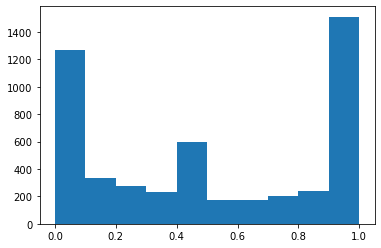

In [38]:
# Predict probability and see histogram
plt.hist(predict_prob(allcat_X, net2))
plt.show()

In [39]:
allcat_data["pred_prob"] = predict_prob(allcat_X, net2)
allcat_data.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,pred_prob
0,4336,929838.0,christianpost.com,reliable,https://www.christianpost.com/news/jesus-chris...,(Photo: Reuters/Danny Moloshok) Tyler Perry sp...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Roles of Jesus Christ, Judas Cast in Tyler Per...",NaN,NaN,[''],The actors who will portray Jesus Christ and J...,NaN,NaN,NaN,0.000043
1,8066,934184.0,christianpost.com,reliable,https://www.christianpost.com/news/cannibalism...,(Screengrab: YouTube / RWW Blog) Televangelist...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Cannibalism in the End Times? Jim Bakker Says ...,NaN,NaN,[''],Televangelist Jim Bakker has warned viewers of...,NaN,NaN,NaN,0.019275
2,2776,479786.0,nutritionfacts.org,reliable,https://nutritionfacts.org/audio/to-pee-or-not...,Hello and welcome to Nutrition Facts. I’m your...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,To Pee or not to Pee,NaN,NaN,[''],NaN,NaN,NaN,NaN,0.379530
3,2070,781392.0,christianpost.com,reliable,https://www.christianpost.com/news/hp-ceo-leo-...,Hewlett-Packard Co has ousted CEO Leo Apotheke...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"HP CEO Leo Apotheker Fired, Meg Whitman Takes ...",NaN,NaN,[''],Hewlett-Packard Co has ousted CEO Leo Apotheke...,NaN,NaN,NaN,0.017374
4,405,471.0,christianpost.com,reliable,https://www.christianpost.com/news/nsa-has-bee...,REUTERS/Pawel Kopczynski An illustration pictu...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,NSA Has Been Running a Voice-Recognition Syste...,NaN,NaN,[''],The National Security Agency has reportedly be...,NaN,NaN,NaN,0.074589


In [40]:
allcat_data[["pred_prob","type"]].groupby(["type"]).median()

,pred_prob
type,
bias,0.870998
clickbait,0.402490
conspiracy,0.986072
fake,0.993442
hate,0.433329
junksci,0.975060
political,0.109233
reliable,0.017557
satire,0.002939


In [41]:
allcat_data["pred_prob"].median()

0.4292108714580536

## Kaggle

In [42]:
# Here get a data from DistilBERT - either calculate them and save or load them
load_mode = True # True = only load, False = recalculate

kaggle_data = pd.read_json(my_dir + 'test_set.json/test_set.json', orient='records')
if load_mode:
  kaggle_score_data = pd.read_csv(my_dir + "kaggle_score_data.csv")
else:
  kaggle_data = pd.read_json(my_dir + 'test_set.json/test_set.json', orient='records')
  
  # Use DistilBERT
  kaggle_data_x = embeddings_distilbert(kaggle_data["article"],1)
  kaggle_data_after_bert = pd.concat([kaggle_data, pd.DataFrame(kaggle_data_x)], axis=1)

  # Add features
  kaggle_score_data = add_features(kaggle_data_after_bert, "article")

  # Save
  kaggle_score_data.to_csv(my_dir + "kaggle_score_data.csv", index = False)

print(kaggle_score_data.shape)
kaggle_score_data.head()

(6335, 781)


,id,article,0,1,2,3,4,5,6,7,...,exclamation_mark_binary,question_mark_count,question_mark_binary,missing_whitespace_count,vocabulary_size,average_sentence_count,swearword_binary,free_count,trump_count,dollar_count
0,8476,"Daniel Greenfield, a Shillman Journalism Fello...",-0.235716,-0.073718,-0.061959,0.040832,-0.085612,-0.189205,-0.096872,0.226301,...,0,3,1,0,582,87.395349,0,0,2,0
1,10294,Google Pinterest Digg Linkedin Reddit Stumbleu...,0.014883,-0.036141,0.200797,0.153579,-0.047223,-0.175186,0.131524,0.276761,...,0,0,0,3,287,91.241379,0,0,8,0
2,3608,U.S. Secretary of State John F. Kerry said Mon...,-0.347795,-0.011390,0.160139,0.155785,-0.058018,-0.132682,-0.210596,0.266900,...,0,0,0,2,252,101.720000,0,0,0,0
3,10142,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0.037265,-0.112581,-0.034120,0.060214,-0.081085,-0.028430,0.086058,0.116612,...,1,0,0,1,261,147.777778,0,0,4,0
4,875,It's primary day in New York and front-runners...,-0.289572,-0.325648,-0.013354,-0.041397,-0.123089,-0.136803,0.109430,0.024566,...,1,0,0,1,189,83.636364,0,0,7,0


In [43]:
kaggle_data = pd.read_json(my_dir + 'test_set.json/test_set.json', orient='records')
print(kaggle_data.head())

      id                                            article
0   8476  Daniel Greenfield, a Shillman Journalism Fello...
1  10294  Google Pinterest Digg Linkedin Reddit Stumbleu...
2   3608  U.S. Secretary of State John F. Kerry said Mon...
3  10142  — Kaydee King (@KaydeeKing) November 9, 2016 T...
4    875  It's primary day in New York and front-runners...


In [44]:
# Save X for prediction
kaggle_X = kaggle_score_data.iloc[:,2:]
print(kaggle_X.head())

          0         1         2         3         4         5         6  \
0 -0.235716 -0.073718 -0.061959  0.040832 -0.085612 -0.189205 -0.096872   
1  0.014883 -0.036141  0.200797  0.153579 -0.047223 -0.175186  0.131524   
2 -0.347795 -0.011390  0.160139  0.155785 -0.058018 -0.132682 -0.210596   
3  0.037265 -0.112581 -0.034120  0.060214 -0.081085 -0.028430  0.086058   
4 -0.289572 -0.325648 -0.013354 -0.041397 -0.123089 -0.136803  0.109430   

          7         8         9  ...  exclamation_mark_binary  \
0  0.226301 -0.045092 -0.112854  ...                        0   
1  0.276761 -0.036136 -0.249296  ...                        0   
2  0.266900  0.141621 -0.239753  ...                        0   
3  0.116612 -0.023817 -0.037898  ...                        1   
4  0.024566 -0.145029 -0.504765  ...                        1   

   question_mark_count  question_mark_binary  missing_whitespace_count  \
0                    3                     1                         0   
1         

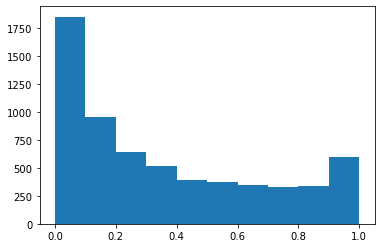

In [45]:
# Predict probability and see histogram
plt.hist(predict_prob(kaggle_X, net2))
plt.show()

In [46]:
# Find best threshold
best_threshold = np.median(predict_prob(kaggle_X, net2)) # data 50:50
print(best_threshold)

# Predict by that threshold
kaggle_pred = np.where(predict_binary(kaggle_X, net2, 0.5)==1, "FAKE", "REAL") 

Counter(kaggle_pred)

0.25308067


Counter({'REAL': 4355, 'FAKE': 1980})

In [47]:
# Prepare submit data to the right format
submit_data = kaggle_data.copy()
submit_data["label"] = kaggle_pred
submit_data = submit_data.drop(columns=["article"])

submit_data.head()

,id,label
0,8476,REAL
1,10294,FAKE
2,3608,REAL
3,10142,FAKE
4,875,REAL


In [48]:
# Save submit data
submit_data.to_csv(my_dir + "submission_after.csv", index = False)

## LIAR

In [49]:
data_LIAR = pd.read_csv(my_dir + "our_data_LIAR.csv",sep=',', header=0, index_col=0)
data_LIAR.head()

,id,content,target
0,11972.json,Building a wall on the U.S.-Mexico border will...,REAL
1,5962.json,Over the past five years the federal governmen...,REAL
2,7070.json,Says that Tennessee law requires that schools ...,REAL
3,12849.json,Donald Trump is against marriage equality. He ...,REAL
4,4888.json,Says the unemployment rate for college graduat...,REAL


In [50]:
# Here get a data from DistilBERT - either calculate them and save or load them
load_mode = False # True = only load, False = recalculate


if load_mode:
  LIAR_score_data = pd.read_csv(my_dir + "LIAR_score_data.csv")
else:
  LIAR_data = data_LIAR.copy()
  
  # Use DistilBERT
  LIAR_data_x = embeddings_distilbert(LIAR_data.content,1)
  LIAR_data_after_bert = pd.concat([LIAR_data, pd.DataFrame(LIAR_data_x)], axis=1)

  # Add features
  LIAR_score_data = add_features(LIAR_data_after_bert, "content")

  # Save
  LIAR_score_data.to_csv(my_dir + "LIAR_score_data.csv", index = False)

print(LIAR_score_data.shape)
LIAR_score_data.head()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokenization DONE
Padding DONE
0
Embeddings DONE
(790, 782)


,id,content,target,0,1,2,3,4,5,6,...,exclamation_mark_binary,question_mark_count,question_mark_binary,missing_whitespace_count,vocabulary_size,average_sentence_count,swearword_binary,free_count,trump_count,dollar_count
0,11972.json,Building a wall on the U.S.-Mexico border will...,REAL,0.146081,-0.147743,0.005782,-0.150747,0.056791,-0.362295,0.129812,...,0,0,0,1,11,17.0,0,0,0,0
1,5962.json,Over the past five years the federal governmen...,REAL,-0.297198,0.080091,-0.389786,-0.110246,0.043642,0.149937,0.294777,...,0,0,0,0,21,74.5,0,0,0,0
2,7070.json,Says that Tennessee law requires that schools ...,REAL,-0.129035,-0.304517,-0.428731,-0.028575,0.131401,-0.094612,0.435311,...,0,0,0,0,25,77.5,0,0,0,0
3,12849.json,Donald Trump is against marriage equality. He ...,REAL,-0.278743,-0.430292,-0.103802,-0.010968,-0.183156,-0.286978,0.316287,...,0,0,0,0,11,21.0,0,0,1,0
4,4888.json,Says the unemployment rate for college graduat...,REAL,-0.214627,0.080253,-0.154860,0.098646,-0.002762,0.185149,0.213731,...,0,0,0,1,14,36.0,0,0,0,0


In [51]:
LIAR_X = LIAR_score_data.iloc[:,3:]
print(LIAR_X.head())


          0         1         2         3         4         5         6  \
0  0.146081 -0.147743  0.005782 -0.150747  0.056791 -0.362295  0.129812   
1 -0.297198  0.080091 -0.389786 -0.110246  0.043642  0.149937  0.294777   
2 -0.129035 -0.304517 -0.428731 -0.028575  0.131401 -0.094612  0.435311   
3 -0.278743 -0.430292 -0.103802 -0.010968 -0.183156 -0.286978  0.316287   
4 -0.214627  0.080253 -0.154860  0.098646 -0.002762  0.185149  0.213731   

          7         8         9  ...  exclamation_mark_binary  \
0  0.202717 -0.003260 -0.414731  ...                        0   
1  0.305387 -0.338505 -0.171483  ...                        0   
2  0.223624 -0.102095 -0.125591  ...                        0   
3  0.465870 -0.220259 -0.415867  ...                        0   
4  0.661956 -0.173590 -0.119121  ...                        0   

   question_mark_count  question_mark_binary  missing_whitespace_count  \
0                    0                     0                         1   
1         

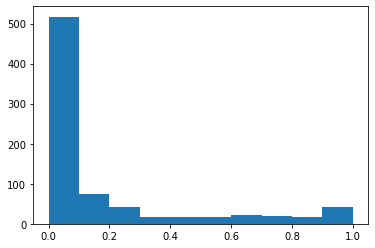

In [52]:
# Predict probability and see histogram
plt.hist(predict_prob(LIAR_X, net2))
plt.show()

In [53]:
from sklearn.metrics import accuracy_score
# Find best threshold
threshold1 = np.median(predict_prob(LIAR_X, net2)) # data 50:50


# Predict by that threshold
LIAR_pred = np.where(predict_binary(LIAR_X, net2, 0.5)==1, "FAKE", "REAL") 
true_val = data_LIAR.target

accuracy_score(true_val,LIAR_pred)



0.5936708860759494